In [21]:
import numpy as np
import cv2
import time
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
import networkx as nx
import matplotlib.pyplot as plt
import hashlib
from google.colab.patches import cv2_imshow
import random


def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    return img

In [22]:
def arnolds_cat_map(img, iterations=5):
    N = img.shape[0]
    scrambled = img.copy()
    for _ in range(iterations):
        temp = np.zeros_like(scrambled)
        for x in range(N):
            for y in range(N):
                new_x = (x + y) % N
                new_y = (x + 2*y) % N
                temp[new_x, new_y] = scrambled[x, y]
        scrambled = temp
    return scrambled

In [23]:
def generate_logistic_key(seed, size):
    x = seed
    key = []
    for _ in range(size):
        x = 3.99 * x * (1 - x)
        key.append(int(x * 256) % 256)
    return np.array(key, dtype=np.uint8).reshape((16, 16))

def get_seed_from_image(img):
    img_hash = hashlib.sha256(img.tobytes()).hexdigest()
    seed_int = int(img_hash[:8], 16)
    seed = (seed_int % 1000000) / 1000000.0
    return seed if 0.01 < seed < 0.99 else 0.7

def blockwise_encrypt(img, key_block):
    h, w = img.shape
    block_size = 16
    encrypted = np.zeros_like(img)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = img[i:i+block_size, j:j+block_size]
            if block.shape == key_block.shape:
                encrypted[i:i+block_size, j:j+block_size] = cv2.bitwise_xor(block, key_block)
            else:
                padded = np.zeros_like(key_block)
                padded[:block.shape[0], :block.shape[1]] = block
                encrypted_block = cv2.bitwise_xor(padded, key_block)
                encrypted[i:i+block.shape[0], j:j+block.shape[1]] = encrypted_block[:block.shape[0], :block.shape[1]]
    return encrypted

In [24]:
def simulate_network_flow():
    G = nx.DiGraph()
    edges = [('Source', 'A', 10), ('Source', 'B', 5), ('A', 'C', 15), ('B', 'C', 10), ('C', 'Sink', 10)]
    for u, v, c in edges:
        G.add_edge(u, v, capacity=c)
    flow_value, flow_dict = nx.maximum_flow(G, 'Source', 'Sink')
    return flow_value, flow_dict

In [25]:
def blockwise_decrypt(img, key_block):
    return blockwise_encrypt(img, key_block)

def inverse_arnolds_cat_map(img, iterations=5):
    N = img.shape[0]
    unscrambled = img.copy()
    for _ in range(iterations):
        temp = np.zeros_like(unscrambled)
        for x in range(N):
            for y in range(N):
                new_x = (2*x - y) % N
                new_y = (-x + y) % N
                temp[new_x, new_y] = unscrambled[x, y]
        unscrambled = temp
    return unscrambled

In [26]:
def evaluate(original, decrypted):
    mse = np.mean((original - decrypted) ** 2)
    psnr = float('inf') if mse == 0 else 10 * np.log10(255 ** 2 / mse)
    ssim_index = ssim(original, decrypted)
    entropy_orig = entropy(np.histogram(original, bins=256)[0] + 1)
    entropy_decrypted = entropy(np.histogram(decrypted, bins=256)[0] + 1)
    return mse, psnr, ssim_index, entropy_orig, entropy_decrypted

In [27]:
def generate_hash(image):
    return hashlib.sha256(image.tobytes()).hexdigest()

def differential_attack(original):
    perturbed = original.copy()
    mask = np.random.random(original.shape) < 0.1
    noise = np.random.randint(-50, 50, original.shape)
    perturbed = np.clip(perturbed.astype(np.int16) + noise * mask, 0, 255).astype(np.uint8)
    perturbed[100:150, 100:150] = 255 - perturbed[100:150, 100:150]
    return perturbed


--- Encryption/Decryption Evaluation ---
Execution Time: 0.22 seconds
MSE: 0.00, PSNR: inf, SSIM: 1.0000
Entropy - Original: 1.71, Decrypted: 1.71
Hashes Match: True
Simulated Max Flow: 10, Flow Dict: {'Source': {'A': 5, 'B': 5}, 'A': {'C': 5}, 'B': {'C': 5}, 'C': {'Sink': 10}, 'Sink': {}}

--- Differential Attack Simulation ---
With correct key - MSE: 9.83, SSIM: 0.6685
With wrong key - MSE: 100.91, SSIM: 0.0018
Difference in encrypted images - MSE: 100.89, NPCR: 98.19%

--- Displaying Images ---
Original Image:


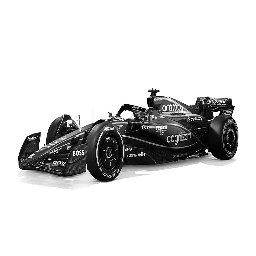

Encrypted Image:


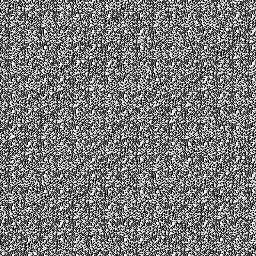

Decrypted Image:


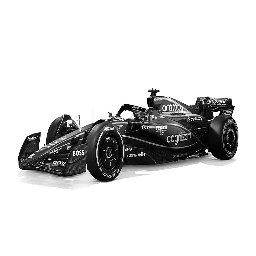

Differentially Attacked Image:


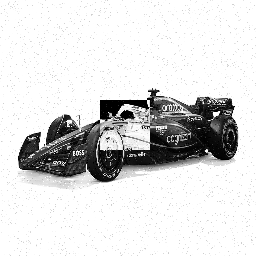

Decrypted with Correct Key:


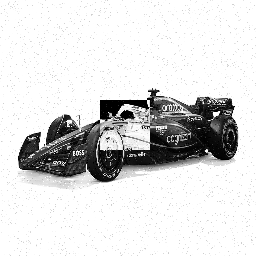

Decrypted with Wrong Key:


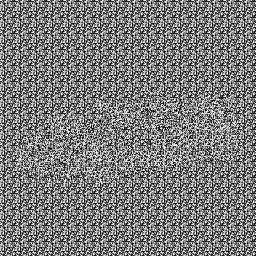

In [28]:

def main():
    img = preprocess_image('/content/aston-martin.jpg')
    hash_original = generate_hash(img)
    seed = get_seed_from_image(img)
    key = generate_logistic_key(seed=seed, size=256)
    start = time.time()
    scrambled = arnolds_cat_map(img)
    encrypted = blockwise_encrypt(scrambled, key)
    flow_val, flow_dict = simulate_network_flow()
    decrypted_blocks = blockwise_decrypt(encrypted, key)
    unscrambled = inverse_arnolds_cat_map(decrypted_blocks)
    hash_decrypted = generate_hash(unscrambled)
    end = time.time()
    mse, psnr, ssim_index, entropy_o, entropy_d = evaluate(img, unscrambled)

    print("\n--- Encryption/Decryption Evaluation ---")
    print(f"Execution Time: {end - start:.2f} seconds")
    print(f"MSE: {mse:.2f}, PSNR: {psnr}, SSIM: {ssim_index:.4f}")
    print(f"Entropy - Original: {entropy_o:.2f}, Decrypted: {entropy_d:.2f}")
    print(f"Hashes Match: {hash_original == hash_decrypted}")
    print(f"Simulated Max Flow: {flow_val}, Flow Dict: {flow_dict}")

    print("\n--- Differential Attack Simulation ---")
    diff_img = differential_attack(img)
    seed_diff = get_seed_from_image(diff_img)
    key_diff = generate_logistic_key(seed=seed_diff, size=256)
    scrambled_diff = arnolds_cat_map(diff_img)
    encrypted_diff = blockwise_encrypt(scrambled_diff, key_diff)
    decrypted_correct_key = blockwise_decrypt(encrypted_diff, key_diff)
    unscrambled_correct = inverse_arnolds_cat_map(decrypted_correct_key)
    decrypted_wrong_key = blockwise_decrypt(encrypted_diff, key)
    unscrambled_wrong = inverse_arnolds_cat_map(decrypted_wrong_key)
    mse_correct, _, ssim_correct, _, _ = evaluate(img, unscrambled_correct)
    mse_wrong, _, ssim_wrong, _, _ = evaluate(img, unscrambled_wrong)
    mse_encrypted = np.mean((encrypted - encrypted_diff) ** 2)
    npcr = np.mean(encrypted != encrypted_diff) * 100

    print(f"With correct key - MSE: {mse_correct:.2f}, SSIM: {ssim_correct:.4f}")
    print(f"With wrong key - MSE: {mse_wrong:.2f}, SSIM: {ssim_wrong:.4f}")
    print(f"Difference in encrypted images - MSE: {mse_encrypted:.2f}, NPCR: {npcr:.2f}%")

    print("\n--- Displaying Images ---")
    print("Original Image:")
    cv2_imshow(img)
    print("Encrypted Image:")
    cv2_imshow(encrypted)
    print("Decrypted Image:")
    cv2_imshow(unscrambled)
    print("Differentially Attacked Image:")
    cv2_imshow(diff_img)
    print("Decrypted with Correct Key:")
    cv2_imshow(unscrambled_correct)
    print("Decrypted with Wrong Key:")
    cv2_imshow(unscrambled_wrong)

if __name__ == '__main__':
    main()